In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
!pip install langchain unstructured[all-docs] pydantic lxml opencv-python

In [3]:
!pip install langchain_core
!pip install langchain-google-genai
!pip install langchain
!pip install langchain_community

In [4]:
%pip install -U nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [234]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [144]:
import os
from google.colab import userdata
GOOGLE_API_KEYS =userdata.get('GOOGLE_API_KEYS')
os.environ["GOOGLE_API_KEYS"] = GOOGLE_API_KEYS

In [7]:
output_path = "./images"

In [8]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="/content/HKDSE_PHYSICS_PAST_PAPER_1_ENG.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
raw_pdf_elements

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [152]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
model = ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-pro")
prompt = ChatPromptTemplate.from_template(summary_prompt)

summary_chain = {"element_type": lambda x: x["element_type"], "element": lambda x: x["element"]} | prompt | model | StrOutputParser()

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.invoke({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.invoke({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

In [99]:
text_elements[0]

"PP-DSE  PHY  \n\nPP-DSE PHY\n\nHONG KONG EXAMINATIONS AND ASSESSMENT AUTHORITY HONG KONG DIPLOMA OF SECONDARY EDUCATION EXAMINATION\n\nPRACTICE PAPER\n\nPRACTICE PAPER\n\nPHYSICS PAPER 1\n\nPHYSICS PAPER 1\n\n(2 hours 30 minutes)\n\nThis paper must be answered\n\nin English\n\nGENERAL INSTRUCTIONS\n\nA and B, in this Paper. You are advised to伽shSection 1. There are TWO sections, 60 minutes.\n\nA in about\n\nquestion A consists paper, while Section of multiple-choice questions in this 2. Section conventional printed in Question-Answer separately questions Book B.\n\nB contains\n\nA should be marked on the Multiple-choice 3. Answers Answer Sheet while answers to to Section B should be written in Question-Answer Section Sheet for Section A and the Question-Answer at the end of the examination. separately Book B. The Answer Book for Section B will be collected in the spaces provided\n\n4. The diagrams in this paper are NOT necessarily drawn to scale\n\na list of data, formulae and relatio

In [100]:
text_summaries[0]

"This text is the cover page of a practice paper for the Hong Kong Diploma of Secondary Education Examination (HKDSE) in Physics Paper 1. It outlines the exam format, instructions, and important details for students taking the exam. \n\nHere's a summary of the key points:\n\n* **Exam Format:** The paper is divided into two sections: Section A (multiple-choice questions) and Section B (conventional questions).\n* **Time Limit:** The exam lasts 2 hours and 30 minutes.\n* **Language:** The exam must be answered in English.\n* **Answering Instructions:** Section A answers are marked on a separate Multiple-Choice Answer Sheet, while Section B answers are written in the Question-Answer Book.\n* **Diagrams:** Diagrams in the paper are not drawn to scale.\n* **Data and Formulae:** The last pages of the paper contain a list of data, formulae, and relationships that may be useful for answering questions.\n* **Multiple-Choice Instructions:** Students are instructed to read the instructions carefu

In [25]:
len(table_summaries)

6

In [26]:
len(text_summaries)

13

In [27]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatGoogleGenerativeAI(model="gemini-1.5-flash").invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [28]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 87.0 MB/s eta 0:00:00


In [201]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"))
retriever = vectorstore.as_retriever()

In [202]:
vectorstore.save_local("faiss_index")

In [212]:
prompt_template = """
You are an expert in maths question solving guides that contains specification, features, etc.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [213]:
# chain = (
#     {"context": retriever, "question": RunnablePassthrough()}
#     | prompt
#     | model
#     | StrOutputParser()
# )

In [214]:
# from langchain.storage import InMemoryStore
# store = InMemoryStore()
# id_key = "doc_id"
# retriever = MultiVectorRetriever(
#     vectorstore=vectorstore,
#     docstore=store,
#     id_key=id_key,
# )


In [223]:
qa_chain = LLMChain(llm=ChatGoogleGenerativeAI(model="gemini-1.5-pro", max_tokens=1024),
                        prompt=ChatPromptTemplate.from_template(prompt_template))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [224]:
qa_chain

LLMChain(prompt=ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nYou are an expert in maths question solving guides that contains specification, features, etc.\nAnswer the question based only on the following context, which can include text, images and tables:\n{context}\nQuestion: {question}\nDon\'t answer if you are not sure and decline to answer and say "Sorry, I don\'t have much information about it."\nJust return the helpful answer in as much as detailed possible.\nAnswer:\n'))]), llm=ChatGoogleGenerativeAI(model='models/gemini-1.5-pro', client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7908461774f0>, async_client=<google.ai.generativelanguage_v1beta.services.generative_service.async_client.GenerativeServiceAsyncClient object at 0x7908461c9630>, default_metadata=()))

In [225]:
from langchain_core.runnables import RunnablePassthrough
prompt = ChatPromptTemplate.from_template(prompt_template)


In [239]:
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    chain = (
    {"context": lambda x: context, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser())
    result= chain.invoke(question)
    # result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [240]:
q= "As shown above, a ray of light travels from medium 1 to medium 2, and then enters medium 3. The boundaries are parallel to each other. Arrange the speed of light, c, in the three media in ascending order."

In [241]:
result, relevant_images = answer(q)
print(result)

Here's how to determine the order of the speed of light in the three mediums:

**Understanding Refraction**

* **Light Speed and Mediums:** Light travels at different speeds through different mediums. Its speed is fastest in a vacuum and slower in other substances. 
* **Refraction:** When light passes from one medium to another, it changes direction. This bending of light is called refraction.
* **Relationship between Speed and Refraction:**
    * When light travels from a *faster* medium to a *slower* medium, it bends *towards* the normal (the imaginary line perpendicular to the surface).
    * When light travels from a *slower* medium to a *faster* medium, it bends *away* from the normal.

**Analyzing the Diagram**

1. **Medium 1 to Medium 2:** The light ray bends *towards* the normal. This means the speed of light in medium 1 is *faster* than in medium 2 (c₁ > c₂).

2. **Medium 2 to Medium 3:** The light ray bends *away* from the normal. This means the speed of light in medium 2 is 

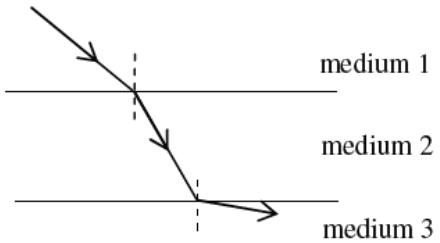

In [242]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [243]:
q1 = "A disc of mass 0.1 kg and velocity 5m * s ^ - 1 strikes a stationary disc of mass 0.2 kg on a smooth table. After the collision, the 0.1 kg disc moves with a speed of 3m * s ^ - 1 at 50° to the x direction. Find the component of the velocity of the 0.2 kg disc in y direction, v_{y} after the collision."

In [244]:
result, relevant_images = answer(q1)
print(result)

Here's how to solve this problem:

**Understanding the Concepts**

* **Conservation of Momentum:** In a closed system, the total momentum before a collision equals the total momentum after the collision. Momentum is calculated as mass (m) times velocity (v).
* **Two-Dimensional Collisions:**  Since the objects move at an angle after the collision, we need to break down their velocities into x and y components.

**Setting up the Solution**

1. **Define the variables:**
   * m₁ = 0.1 kg (mass of the first disc)
   * m₂ = 0.2 kg (mass of the second disc)
   * u₁x = 5 m/s (initial x-velocity of the first disc)
   * u₁y = 0 m/s (initial y-velocity of the first disc)
   * u₂x = 0 m/s (initial x-velocity of the second disc)
   * u₂y = 0 m/s (initial y-velocity of the second disc)
   * v₁x = 3cos(50°) m/s (final x-velocity of the first disc)
   * v₁y = 3sin(50°) m/s (final y-velocity of the first disc)
   * v₂x = ? (final x-velocity of the second disc)
   * v₂y = ? (final y-velocity of the sec

In [245]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFxAlIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorjPif4t/4RHwfcXMT7bycGK39Qx/iH0yDQB2dcf4+8Q6v4Z0+DULBIJLfzVSYS

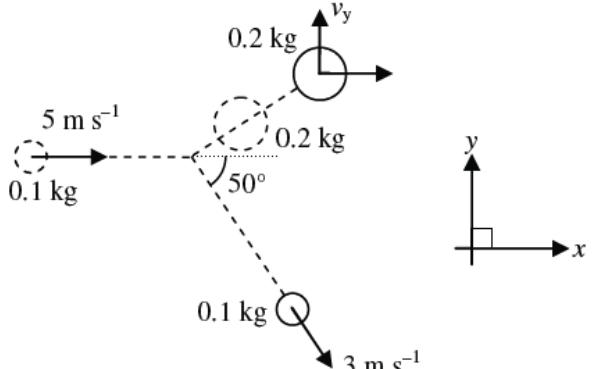

In [246]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [ ]:
# Display result
result, relevant_images = answer("sprinkler system")
print(result)

The diagram shows a simplified illustration of a rooftop sprinkler system for cooling purposes. Here's how it works and why it's effective:

* **Evaporative Cooling:** The core principle is the process of evaporation. When water droplets from the sprinklers land on the hot rooftop surface, they absorb heat from the roof and the surrounding air. This absorbed heat transforms the liquid water into water vapor (a gas) – the process of evaporation.

* **High Latent Heat of Vaporization:**  Water has a high latent heat of vaporization, meaning it requires a significant amount of heat energy to change from liquid to vapor.  As the water droplets on the roof evaporate, they draw this needed heat from their surroundings, effectively cooling down the rooftop surface.

* **Continuous Cycle:** The sprinkler system provides a continuous supply of water. As older droplets evaporate, new ones are sprayed on, maintaining the cooling effect.

**Benefits:**

* **Reduced Cooling Costs:** By lowering the

In [ ]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEoAdQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAELBVLMQAOpNRidJIDLAyzDBI2MCG9s1y/i/Qdb8Rz29ha6gLHSjzdPGSJX9ge351v6PpNtoelQadaBvJhXC72LE98kmgDkk8UeMrm9K2/hAi2EuwySXCA4

In [247]:
q2 = "In Figure (a), two identical resistors are connected in series to a cell of e.m.f. V and negligible internal resistance. The power dissipated by each resistor is P. If the two resistors are now connected in parallel as shown in Figure (b), what is the power dissipated by each resistor ?"

In [248]:
result, relevant_images = answer(q2)
print(result)

## Determining Power Dissipation in Series and Parallel Resistors

Here's how to solve this problem:

**Understanding the Concepts**

* **Resistors in Series:** When resistors are connected in series, the total resistance is the sum of the individual resistances (R_total = R1 + R2). The current flowing through each resistor is the same.
* **Resistors in Parallel:** When resistors are connected in parallel, the reciprocal of the total resistance is the sum of the reciprocals of the individual resistances (1/R_total = 1/R1 + 1/R2). The voltage across each resistor is the same.
* **Power Dissipation:** The power dissipated by a resistor is given by P = V^2/R or P = I^2*R, where V is the voltage across the resistor, I is the current flowing through the resistor, and R is the resistance.

**Solving the Problem**

1. **Series Connection (Figure a):**
   * Let each resistor have resistance R.
   * Total resistance: R_total = R + R = 2R
   * Current through the circuit: I = V/R_total = V/(2R)


In [249]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADjAQgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigDifFPxBbwvr1hpUmiz3DX0gjglSZVVmJxjnp1rpdT1OXTdEm1BrQu8MZkaHzVU8DJG48V518bYvKtPD+qgYNlfq5b0yV/wrf1yeTxJPp3h+2f8AdSxpc3zqfux9Qv1JA/

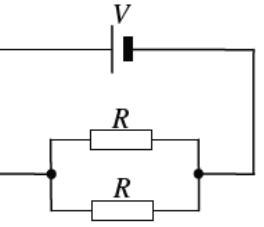

In [250]:
display.display(display.Image(base64.b64decode(relevant_images[0])))